# Segmentation workflow using PyTorch (U-Net/CNN) for flood and water mask detection

1. **Data Acquisition**:
   - Downloading the [Tropical and Sub-Tropical Flood and Water Masks dataset](https://pacificdata.org/data/dataset/tropical-and-sub-tropical-flood-and-water-masks).
   - Fetching Sentinel-1 RTC (for SAR-based flood detection) and Sentinel-2 imagery from STAC for Vanuatu and the relevant surrounding region.

2. **Preprocessing**:
   - Aligning Sentinel-1 and/or Sentinel-2 data.
   - Normalization, filtering, and masking.
   - Preparing training data by pairing inputs (SAR and/or optical images) with water masks.

3. **Model Definition**:
   - Implementing a U-Net (CNN) in PyTorch for segmentation.

4. **Training & Evaluation**:
   - Splitting data into train/val/test sets.
   - Data loading through batches.
   - Loss function and optimizer.
   - Model training loop.
   - Performance evaluation with IoU and Accuracy Score.

5. **Inference & Visualization**:
   - Running the model on test images.
   - Plotting predicted masks.

This sets up a basic segmentation pipeline using U-Net and PyTorch, processing Sentinel-1/2 data for flood and water masks.

In [8]:
import os
import glob
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models.resnet import resnet34
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
import xarray as xr
import rioxarray as rxr
import planetary_computer
import pystac_client
import odc.stac
import matplotlib.pyplot as plt
from shapely.geometry import box
from sklearn.metrics import jaccard_score, accuracy_score
import dask
import dask.array as da
import dask.delayed

In [ ]:
cd ./vbos/flood/

The **Tropical and Sub-Tropical Flood and Water Masks** dataset provides 10-meter spatial resolution masks designed for developing machine learning models to classify flooding in satellite imagery. It comprises 513 GeoTIFF files, each corresponding to specific flood events and dates, covering 65 flood events since 2018 across 26 countries in tropical and sub-tropical regions.

**Dataset Composition:**
- **Classes:**
  - `0`: No data
  - `1`: Land (not flooded)
  - `2`: Flooded areas
  - `3`: Permanent water bodies
- **Associated Dates:**
  - **Activation Date:** Date when the flood event was registered in the [EMS Rapid Mapping system](https://mapping.emergency.copernicus.eu/).
  - **Event Date:** Initial date of the flood occurrence.
  - **Satellite Date:** Date of the latest satellite imagery used for generating the flood mask.

The masks were generated by integrating data from the [ESA WorldCover 10m v100 product](https://worldcover2020.esa.int/) and vector layers from the Copernicus Emergency Management System (EMS) Rapid Mapping Activation events. 

This dataset is particularly useful for training flood detection models to identify and segment flooded areas in satellite images, and we'll use it in the specific geographic context of the Pacific region.

The dataset is licensed under the Creative Commons Attribution-NonCommercial 4.0 License.

Obtain the data [here](https://pacificdata.org/data/dataset/tropical-and-sub-tropical-flood-and-water-masks) by clicking "Download all data (81.56 MB)" and then unzip the folder. The labels will be in a subfolder called 'tst-ground-truth-flood-masks' and accompanied by a metadata file which we will use for filtering and image acquisition.

In [4]:
# Get list of all labels
mask_paths = glob.glob('tst-ground-truth-flood-masks/*.tif')

In [5]:
len(mask_paths)

513

In [25]:
ls tst-ground-truth-flood-masks/ | head

EMSR264_01AMBILOPE_DEL_v2_ground_truth.tif
EMSR264_02AMBANJA_DEL_v2_ground_truth.tif
EMSR264_05MAROVOAY_DEL_v2_ground_truth.tif
EMSR264_06MAHAMBO_DEL_v2_ground_truth.tif
EMSR264_07AMBATOBE_DEL_v2_ground_truth.tif
EMSR264_08VATOMANDRY_DEL_v2_ground_truth.tif
EMSR264_09MAHANORO_DEL_v1_ground_truth.tif
EMSR264_10MASOMELOKA_DEL_v2_ground_truth.tif
EMSR264_11NOSYVARIKA_DEL_v2_ground_truth.tif
EMSR264_12FARAFANGANA_DEL_v2_ground_truth.tif


Let's implement a U-Net model with a **ResNet34** encoder, adapted for image segmentation tasks. The model takes a **two-channel** input and outputs a **four-class** segmentation mask.

This entails our first example of a [convolution neural network (CNN)](https://www.mathworks.com/discovery/convolutional-neural-network.html).

#### Model Architecture

1. **Encoder (Feature Extraction)**
- Uses a **pre-trained ResNet34** as a feature extractor.
- The first convolution layer is modified to accept **two input channels** (VV and VH SAR polarizations) instead of three (RGB).
- The encoder progressively **downsamples** the input image while extracting high-level features:
  - `encoder1`: Initial convolution layer with batch normalization and ReLU.
  - `encoder2` → `encoder5`: ResNet34 convolutional layers, reducing spatial dimensions.

2. **Bottleneck Layer**
- A **1x1 convolution** expands the deepest encoder feature map to **1024 channels**.
- Acts as the bridge between encoder and decoder.

3. **Decoder (Upsampling with Skip Connections)**
- The decoder **upsamples** the feature maps back to the original image resolution.
- Uses **skip connections** to concatenate encoder outputs with corresponding decoder layers.
- Each upsampling layer consists of:
  - **Bilinear interpolation**
  - **3x3 convolution**
  - **ReLU activation**

4. **Final Segmentation Output**
- A **1x1 convolution** reduces the output to **4 channels** (matching the number of segmentation classes).
- Ensures the final output size is **224x224**.

#### Skip Connections and Interpolation Handling
- Since downsampling reduces spatial dimensions, **skip connection tensors are interpolated** to match decoder sizes before concatenation.
- `F.interpolate()` is used to **ensure spatial compatibility**.

#### Forward Pass (Data Flow)
1. Input image (B, 2, 224, 224) → passes through encoder (ResNet34) → generates feature maps. Herein, B stands for batch. That is just a small sample of the dataset provided to the model. We have to break down the dataset and provide in small samples of equal size in order to fit on the available RAM. 
2. Bottleneck layer processes the deepest feature representation.
3. Decoder **upsamples** while concatenating interpolated skip connections from the encoder.
4. Final **segmentation mask** is generated with shape `(B, 4, 224, 224)`.

This architecture should do well for **flood and water segmentation** from Sentinel-1 images, given its ability to retain fine-grained spatial details while leveraging **ResNet34's strong feature extraction**.


In [9]:
# Define U-Net model with ResNet34 backbone
class UNetWithResNetEncoder(nn.Module):
    def __init__(self, in_channels=2, out_channels=4):
        super().__init__()

        # Load pre-trained ResNet34 backbone
        resnet = models.resnet34(pretrained=True)

        # Modify first convolution to accept 2 channels
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            resnet.bn1,
            resnet.relu
        )

        # Encoder layers
        self.encoder2 = resnet.layer1  # (B, 64, H/4, W/4)
        self.encoder3 = resnet.layer2  # (B, 128, H/8, W/8)
        self.encoder4 = resnet.layer3  # (B, 256, H/16, W/16)
        self.encoder5 = resnet.layer4  # (B, 512, H/32, W/32)

        # Bottleneck
        self.bottleneck = nn.Conv2d(512, 1024, kernel_size=3, padding=1)

        # Decoder with skip connections
        self.upconv1 = self._upsample(1024, 512)
        self.upconv2 = self._upsample(512 + 512, 256)  # Add encoder5 skip connection
        self.upconv3 = self._upsample(256 + 256, 128)  # Add encoder4 skip connection
        self.upconv4 = self._upsample(128 + 128, 64)   # Add encoder3 skip connection
        self.upconv5 = self._upsample(64 + 64, 64)     # Add encoder2 skip connection

        # Final segmentation output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def _upsample(self, in_channels, out_channels):
        """Helper function to create upsampling layers."""
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder path
        enc1 = self.encoder1(x)   # (B, 64, 112, 112)
        enc2 = self.encoder2(enc1) # (B, 64, 56, 56)
        enc3 = self.encoder3(enc2) # (B, 128, 28, 28)
        enc4 = self.encoder4(enc3) # (B, 256, 14, 14)
        enc5 = self.encoder5(enc4) # (B, 512, 7, 7)

        # Bottleneck
        x = self.bottleneck(enc5)  # (B, 1024, 7, 7)
        x = self.upconv1(x)        # (B, 512, 14, 14)

        # Ensure enc5 matches x before concatenation
        enc5 = F.interpolate(enc5, size=x.shape[2:], mode="bilinear", align_corners=True)
        x = torch.cat([x, enc5], dim=1)

        x = self.upconv2(x)  # (B, 256, 28, 28)

        # Ensure enc4 matches x before concatenation
        enc4 = F.interpolate(enc4, size=x.shape[2:], mode="bilinear", align_corners=True)
        x = torch.cat([x, enc4], dim=1)

        x = self.upconv3(x)  # (B, 128, 56, 56)

        # Ensure enc3 matches x before concatenation
        enc3 = F.interpolate(enc3, size=x.shape[2:], mode="bilinear", align_corners=True)
        x = torch.cat([x, enc3], dim=1)

        x = self.upconv4(x)  # (B, 64, 112, 112)

        # Ensure enc2 matches x before concatenation
        enc2 = F.interpolate(enc2, size=x.shape[2:], mode="bilinear", align_corners=True)
        x = torch.cat([x, enc2], dim=1)

        x = self.upconv5(x)  # (B, 64, 224, 224)

        # Ensure final output size is exactly (B, 4, 224, 224)
        x = self.final_conv(x)  # (B, 4, 224, 224)
        x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=True)  # Fix output size

        return x

The following functions facilitate fetching Sentinel-1 Radiometrically Terrain Corrected (RTC) imagery from the Microsoft Planetary Computer STAC API, using bounding boxes derived from our raster label data.

`fetch_s1_rtc_for_date(bounds, date)` fetches Sentinel-1 RTC data for a given date (or up to 3 days later) within the specified bounding box.

**How It Works**
1. Connects to the **Microsoft Planetary Computer STAC API**.
2. Defines a **time window** of 3 days starting from the given date.
3. Searches for available **Sentinel-1 RTC** data within the bounding box.
4. Signs STAC items using **Planetary Computer authentication**.
5. Loads the **first available scene** as an **xarray dataset**.

**Inputs**
- `bounds`: Bounding box **(left, bottom, right, top)** specifying the geographic area.
- `date`: The target date **(YYYY-MM-DD format, string)**.

**Returns**
- An **xarray dataset** containing the Sentinel-1 RTC image.
- If no data is found, returns **None**.



`match_s1_rtc_to_dataframe(df, mask_path)` finds and fetches Sentinel-1 RTC imagery corresponding to a given ground truth mask.

**How It Works**
1. Searches for the **specified mask file** (`mask_path`) in the given DataFrame (`df`).
2. Extracts the **satellite image acquisition date**.
3. Converts the date format from **DD/MM/YYYY** to **YYYY-MM-DD**.
4. Reads the **bounding box (extent)** of the mask using **Rasterio**.
5. Calls `fetch_s1_rtc_for_date()` with the mask’s bounding box and acquisition date.
6. Returns the matching Sentinel-1 RTC dataset.

**Inputs**
- `df`: A DataFrame containing mask metadata, including **file names and acquisition dates**.
- `mask_path`: The **file name** of the ground truth flood mask.

**Returns**
- The **corresponding Sentinel-1 RTC image** as an xarray dataset.


These functions are designed to fetch Sentinel-1 RTC data needed to match our flood masks. 

In [10]:
# Function to fetch Sentinel-1 RTC data matching a given date (or up to 3 days after)
def fetch_s1_rtc_for_date(bounds, date):
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    # Define the search time range (3-day + window)
    date = datetime.strptime(date, "%Y-%m-%d")  # Convert to datetime object

    start_date = date.strftime("%Y-%m-%d")
    end_date = (date + timedelta(days=3)).strftime("%Y-%m-%d")

    search = catalog.search(
        collections=["sentinel-1-rtc"],
        bbox=[bounds.left, bounds.bottom, bounds.right, bounds.top],
        datetime=f"{start_date}/{end_date}"
    )

    items = list(search.get_items())
    if not items:
        return None  # No matching data found

    signed_items = [planetary_computer.sign(item) for item in items]

    # Load the first available scene (or refine selection criteria as needed)
    ds = odc.stac.load(signed_items[:1], dtype="float32", chunks={'x': 512, 'y': 512})

    return ds.mean(dim="time") if ds else None  # Take mean if multiple images exist

# Function to find matching Sentinel-1 RTC imagery for each row in DataFrame
def match_s1_rtc_to_dataframe(df, mask_path):
    filtered_row = df.loc[df["File Name"] == mask_path].iloc[0]
    sat_date = filtered_row["Satellite Date"]
    formatted_date = datetime.strptime(sat_date, "%d/%m/%Y").strftime("%Y-%m-%d")


    with rasterio.open(f"tst-ground-truth-flood-masks/{mask_path}_ground_truth.tif") as src:
        bounds = src.bounds  # Get bounding box of the mask

    s1_image = fetch_s1_rtc_for_date(bounds, formatted_date)

    return s1_image

Load the metadata file into a dataframe and select labels for Vanuatu and a relevant surrounding region so as to provide sufficient data for model training.

In [ ]:
# Example DataFrame
df = pd.read_csv('metadata/metadata.csv')
# Filter for specific countries
selected_countries = {"Vanuatu", "Tonga"} #, "Timor-Leste" , "Philippines", "Viet Nam", "Australia"}
df = df[df["Country"].isin(selected_countries)]

"""
# Limit the number of rows for the Philippines
df_philippines = df[df["Country"] == "Philippines"].head(5)  # Keep only 10 rows
df_other = df[df["Country"] != "Philippines"]  # Keep all other countries

# Concatenate back
df = pd.concat([df_philippines, df_other])

# Reset index
df = df.reset_index(drop=True)
"""

print("len(df):", len(df))

Establish a dataset class.

In [ ]:
class FloodDataset(Dataset):
    def __init__(self, mask_paths, transform=None, tile_size=224):
        #self.mask_paths = filter_masks_within_vanuatu(mask_paths)
        self.mask_paths = list(df["File Name"])
        self.transform = transform
        self.image_list = []
        self.mask_list = []
        self.tile_size = tile_size

        # Use Dask Delayed for parallel fetching
        delayed_images = []
        for mask_path in self.mask_paths:
            #s1_image = fetch_stac_data_from_mask(mask_path, "sentinel-1-rtc", "2018-01-01", "2018-12-31")
            #s2_image = fetch_stac_data_from_mask(mask_path, "sentinel-2-l2a", "2018-01-01", "2018-12-31")
            s1_image = match_s1_rtc_to_dataframe(df, mask_path)
            delayed_images.append(dask.delayed(s1_image))

        # Compute all Dask delayed tasks at once (efficient batch processing)
        computed_images = dask.compute(*delayed_images)

        self.image_tiles = []
        self.mask_tiles = []

        for i, mask_path in enumerate(self.mask_paths):
            if computed_images[i] is None:
                continue  # Skip if no data was found

            with rasterio.open(f"tst-ground-truth-flood-masks/{mask_path}_ground_truth.tif") as src:
                mask = src.read(1).astype(np.float32)
            try:
                image_tensor = torch.tensor(computed_images[i].to_array().values, dtype=torch.float32)
                mask_tensor = torch.tensor(mask).unsqueeze(0)

                image_tiles, mask_tiles = self._tile_image_and_mask(image_tensor, mask_tensor)
                self.image_tiles.extend(image_tiles)  # Flatten the dataset
                self.mask_tiles.extend(mask_tiles)
            except:
                print("error when creating tensor")
                continue


    def __len__(self):
        return len(self.image_tiles)

    def __getitem__(self, idx):
        return self.image_tiles[idx], self.mask_tiles[idx]

    def _tile_image_and_mask(self, image, mask):
        #Tiles both the image and mask into patches of size (tile_size x tile_size).

        height, width = image.shape[-2:]  # Ensure compatibility with tensor dimensions
        image_tiles = []
        mask_tiles = []

        for i in range(0, height, self.tile_size):
            for j in range(0, width, self.tile_size):
                # Extract tiles
                image_tile = image[..., i:i + self.tile_size, j:j + self.tile_size]
                mask_tile = mask[..., i:i + self.tile_size, j:j + self.tile_size]

                if mask_tile.shape[-2] == self.tile_size and mask_tile.shape[-1] == self.tile_size and image_tile.shape[-2] == self.tile_size and image_tile.shape[-1] == self.tile_size:
                    image_tiles.append(image_tile.clone().detach())
                    mask_tiles.append(mask_tile.clone().detach())

        return image_tiles, mask_tiles

Generate the dataset and split it into train, validation and test datasets.

In [ ]:
full_dataset = FloodDataset(mask_paths=mask_paths,
                             transform=transforms.Compose([transforms.Normalize(0, 1)]), tile_size=224)

In [ ]:
# Define split sizes
train_size = int(0.7 * len(full_dataset))
val_size = int(0.20 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size  # Ensures total sums up correctly

# Perform split
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
print(f"Dataset sizes -> Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Generate data loaders for each dataset partition.

In [ ]:
# Create DataLoaders
train_loader = DataLoader(train_dataset_, batch_size=2, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, drop_last=True)

Define the loss and optimizer, and commence training.

In [ ]:
# Model, Loss, Optimizer
model = UNetWithResNetEncoder()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Starting training")

# Training Loop
for epoch in range(70):
    model.train()  # Ensure the model is in training mode

    # Training phase
    train_loss = 0.0
    for batch in train_loader:
        images, masks = batch  # Unpack stacked tensors

        if isinstance(images, list):
            images = torch.cat(images, dim=0)  # Ensure 4D tensor (B, C, H, W)
        if isinstance(masks, list):
            masks = torch.cat(masks, dim=0)

        images = torch.stack(images) if isinstance(images, list) else images
        masks = torch.stack(masks) if isinstance(masks, list) else masks
        masks = masks.squeeze()
        masks = masks.long()  # Convert masks to LongTensor before computing loss

        optimizer.zero_grad()
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Average training loss for the epoch
    train_loss /= len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images, masks = batch  # Unpack stacked tensors

            if isinstance(images, list):
                images = torch.cat(images, dim=0)
            if isinstance(masks, list):
                masks = torch.cat(masks, dim=0)

            images = torch.stack(images) if isinstance(images, list) else images
            masks = torch.stack(masks) if isinstance(masks, list) else masks
            masks = masks.squeeze()
            masks = masks.long()  # Convert masks to LongTensor

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    # Average validation loss for the epoch
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Save the model to a file for future use.

In [ ]:
# Directory to save the model checkpoints
MODEL_SAVE_DIR = 'model_s1'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Save the final model after training
final_model_path = os.path.join(MODEL_SAVE_DIR, "final_model_100ep_vnu_tvt_1.pth")
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved at {final_model_path}")

Let's evaluate and visualize results from the model.

In [ ]:
# Inference Function
def inference(model, image):
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0))
        prediction = torch.softmax(output, dim=1).squeeze(0)  # Softmax across channels
        prediction = torch.argmax(prediction, dim=0).cpu().numpy()  # Get class labels
    return prediction

idx:  34
idx:  22
idx:  30
idx:  32
idx:  21
idx:  37
idx:  6
idx:  17
Mean IoU: 0.1823, Mean Accuracy: 0.4356
idx:  34


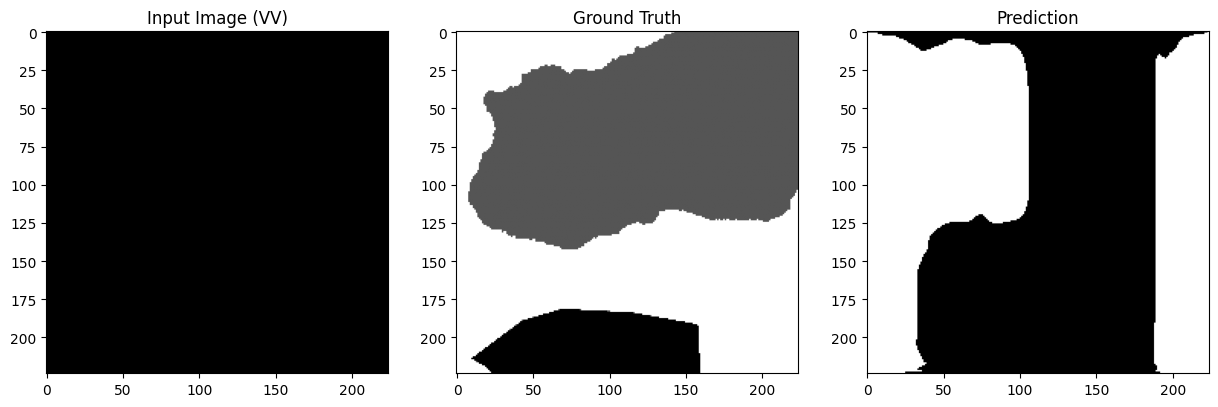

In [12]:
# Evaluation Function
def evaluate(model, data_loader):
    model.eval()
    iou_scores, accuracy_scores = [], []
    with torch.no_grad():
        for images, masks in data_loader:
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)  # Convert [batch, 4, H, W] → [batch, H, W]
            preds = preds.cpu().numpy().flatten()
            masks = masks.cpu().numpy().flatten()
            iou_scores.append(jaccard_score(masks, preds, average="macro"))
            accuracy_scores.append(accuracy_score(masks, preds))
    print(f"Mean IoU: {np.mean(iou_scores):.4f}, Mean Accuracy: {np.mean(accuracy_scores):.4f}")

# Visualization Function
def visualize_prediction(image, mask, prediction):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Convert 2-channel image to single-channel (VV)
    vv_image = image[0].cpu().numpy()  # Use first channel (VV)

    ax[0].imshow(vv_image, cmap="gray")  # Display as grayscale
    ax[0].set_title("Input Image (VV)")

    ax[1].imshow(mask.squeeze(), cmap="gray")
    ax[1].set_title("Ground Truth")

    ax[2].imshow(prediction, cmap="gray")
    ax[2].set_title("Prediction")

    plt.show()


# Run Evaluation
evaluate(model, test_loader)

# Test Inference and Visualization
sample_image, sample_mask = test_dataset[0]
predicted_mask = inference(model, sample_image)
visualize_prediction(sample_image, sample_mask, predicted_mask)


Now let's use an [administrative boundaries file from Pacific Data Hub](https://pacificdata.org/data/dataset/9dba1377-740c-429e-92ce-6a484657b4d9/resource/66ae054b-9b67-4876-b59c-0b078c31e800) to get imagery for Vanuatu and run inference on these areas with our trained model.

In [14]:
admin_boundaries_gdf = gpd.read_file("./2016_phc_vut_iid_4326.geojson").to_crs(epsg="4326")

Load the saved model from file.

In [ ]:
# Define the model architecture (must match the saved model)
model = UNetWithResNetEncoder(in_channels=2, out_channels=4)  # Ensure the same architecture

# Load the model weights
model.load_state_dict(torch.load("model_s1/final_model_100ep_vnu_tvt_1.pth"))

# Set the model to evaluation mode (important for inference)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

New function to get relevant Sentinel-1 imagery.

In [20]:
# Function to fetch Sentinel-1 RTC data matching a given date (or up to 3 days after)
def fetch_s1_rtc_for_date_inference(bounds, date):
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    # Define the search time range (3-day + window)
    date = datetime.strptime(date, "%Y-%m-%d")  # Convert to datetime object

    start_date = date.strftime("%Y-%m-%d")
    end_date = (date + timedelta(days=3)).strftime("%Y-%m-%d")

    search = catalog.search(
        collections=["sentinel-1-rtc"],
        bbox=bounds,
        datetime=f"{start_date}/{end_date}"
    )

    items = list(search.get_items())
    if not items:
        return None  # No matching data found

    signed_items = [planetary_computer.sign(item) for item in items]

    # Load the first available scene (or refine selection criteria as needed)
    ds = odc.stac.load(signed_items, dtype="float32", chunks={'x': 512, 'y': 512}) # signed_items[:1]

    return ds.mean(dim="time") if ds else None  # Take mean if multiple images exist

Get the imagery for each boundary. We are using a date just after a major earthquake as reference here, as floods present a heightened risk post-earthquake.

In [25]:
vanuatu_s1_imagery = []

for idx, row in admin_boundaries_gdf.iterrows():
    polygon = row.geometry
    bbox = polygon.bounds  # (minx, miny, maxx, maxy)
    event_date = '20/12/2024'
    formatted_date = datetime.strptime(event_date, "%d/%m/%Y").strftime("%Y-%m-%d")
    s1_data = fetch_s1_rtc_for_date_inference(bounds=list(bbox), date=formatted_date)
    vanuatu_s1_imagery.append(s1_data)
    admin_name = row.iname
    print("added ", admin_name)

/usr/local/lib/python3.11/dist-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


added  Malmas


/usr/local/lib/python3.11/dist-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


added  ATCHIN
added  VAO
added  TOMMAN
added  LEMBONG
added  AVOKH
added  ULIVEO
added  SAKAO (KHOTI)
added  AKHAMB
added  WALA
added  RANO
added  URI
added  NORSUP
added  URIPIV
added  LAMEN
added  TONGOA
added  BUNINGA
added  MAKIRA
added  EMAE
added  EMAU
added  NGUNA
added  HIDEAWAY
added  KAKULA
added  IRIRIKI
added  LELEPA
added  ANIWA
added  FUTUNA
added  ANEITYUM
added  UREPARAPARA
added  LOH
added  TOGA
added  METOMA
added  HIU
added  MERIG
added  MERE LAVA
added  GAUA


/usr/local/lib/python3.11/dist-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


added  MOTA
added  KWAKEA
added  MAVEA
added  TANGOA
added  ARAKI
added  BOKISSA
added  AORE
added  TANGISI
added  MALO
added  MALOKILIKILI
added  MOTA LAVA
added  RAH
added  PENTECOST
added  AMBAE
added  MAEWO
added  TUTUBA
added  AMBRYM
added  EPI
added  PAAMA
added  MOSO
added  PELE
added  IFIRA
added  ERROMANGO
added  VANUA LAVA
added  TONGARIKI
added  TANNA
added  MALEKULA
added  TEGUA
added  SANTO


/usr/local/lib/python3.11/dist-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


added  EFATE
added  LOPEVI
added  AESE
added  LE THARO
added  LE THARIA
added  URELAPA
added  VENUE
added  REEF
added  LATHU
added  THION


/usr/local/lib/python3.11/dist-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


added  VALA
added  AWEI
added  KHUNEVEO
added  BATGHUTONG
added  MATASO
added  UNKNOWN
added  UNKNOWN
added  UNKNOWN
added  UNKNOWN
added  UNKNOWN
added  UNKNOWN
added  UNKNOWN
added  UNKNOWN
added  UNKNOWN
added  UNKNOWN
added  UNKNOWN


In [26]:
vanuatu_s1_imagery[0]

<xarray.Dataset> Size: 3GB
Dimensions:      (y: 15298, x: 26835)
Coordinates:
  * y            (y) float64 122kB 8.292e+06 8.292e+06 ... 8.445e+06 8.445e+06
  * x            (x) float64 215kB 5.189e+05 5.189e+05 ... 7.872e+05 7.872e+05
    spatial_ref  int32 4B 32758
Data variables:
    vh           (y, x) float32 2GB dask.array<chunksize=(512, 512), meta=np.ndarray>
    vv           (y, x) float32 2GB dask.array<chunksize=(512, 512), meta=np.ndarray>

Tile the images per boundary into 224x224 for input to the UNet-ResNet model.

In [29]:
def tile_and_preprocess(xr_dataset, tile_size=224, stride=224):
    """
    Splits a large Sentinel-1 xarray dataset into smaller 224x224 tiles, ignoring edge tiles that are too small.
    """
    if xr_dataset is not None:
        # Extract VV and VH bands
        vv = xr_dataset["vv"].values  # (H, W)
        vh = xr_dataset["vh"].values  # (H, W)

        # Stack into a 2-channel image (C, H, W)
        full_image = np.stack([vv, vh], axis=0)  # Shape (2, H, W)

        # Image dimensions
        _, H, W = full_image.shape

        # Store tiles
        tiles = []

        # Slide over the image and extract tiles
        for y in range(0, H - tile_size + 1, stride):  # Ensure tile stays within bounds
            for x in range(0, W - tile_size + 1, stride):
                tile = full_image[:, y:y+tile_size, x:x+tile_size]
                tile_tensor = torch.tensor(tile, dtype=torch.float32).unsqueeze(0)  # Add batch dim
                tiles.append(tile_tensor)

        return tiles
    else:
        print("No Sentinel-1 data available for this region around the requested date.")
        return



Run inference on the tiles per admin boundary.

In [ ]:
results = []

for idx, s1_dataset in enumerate(vanuatu_s1_imagery):
    print(f"Processing region {idx}...")

    # Generate tiles
    tiles = tile_and_preprocess(s1_dataset, tile_size=224, stride=224)

    region_results = []

    if tiles:
        for tile in tiles:
            tile = tile.to(device)
            
            # Run inference
            with torch.no_grad():
                output = model(tile)

            # Convert output tensor to NumPy array
            prediction = output.squeeze().cpu().numpy()
            region_results.append(prediction)

        results.append(region_results)
        print(f"Inference completed for region {idx}")
    else:
        print(f"No tiles generated for region {idx}")


Processing region 0...
